In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# [I 2024-12-13 01:18:39,043] Trial 39 finished with value: 0.8016925942757998 and parameters: {'EMBED_DIM': 64, 'LR': 3.591388314145999e-05, 'REG_LAMBDA': 0.001630666920706239, 'BATCH_SIZE': 64, 'PATIENCE': 14}. Best is trial 39 with value: 0.8016925942757998.

# -----------------------
# Hyperparameters
# -----------------------
EMBED_DIM = 64
BATCH_SIZE = 64
LR = 3.591388314145999e-05
EPOCHS = 100
REG_LAMBDA = 1e-1
PATIENCE = 14  # Early stopping patience

# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# -----------------------
# Data Loading
# -----------------------
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv") 

unique_users = train_df.user_id.unique()
unique_books = train_df.book_id.unique()

user2idx = {u: i for i, u in enumerate(unique_users)}
book2idx = {b: i for i, b in enumerate(unique_books)}

train_df["user_idx"] = train_df["user_id"].map(user2idx)
train_df["book_idx"] = train_df["book_id"].map(book2idx)

n_users = len(user2idx)
n_books = len(book2idx)

train_df['user_idx'] = train_df['user_id'].map(user2idx)
train_df['book_idx'] = train_df['book_id'].map(book2idx)


# drop low interaction users from validation set
# low interaction after combining train and test 
data = pd.concat([train_df, test_df])
low_interaction_users = data['user_idx'].value_counts()[data['user_idx'].value_counts() < 5].index

# Create validation split
user_counts = train_df['user_id'].value_counts()
rare_threshold = 4
rare_users = user_counts[user_counts <= rare_threshold].index
non_rare_users = user_counts[user_counts > rare_threshold].index
rare_df = train_df[train_df['user_id'].isin(rare_users)]
non_rare_df = train_df[train_df['user_id'].isin(non_rare_users)]
train_non_rare, val_non_rare = train_test_split(
    non_rare_df, test_size=0.1, stratify=non_rare_df['user_id'], random_state=42
)
rare_train, rare_val = train_test_split(
    rare_df, test_size=0.1, random_state=42
)


train_data = pd.concat([train_non_rare, rare_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_data = pd.concat([val_non_rare, rare_val]).sample(frac=1, random_state=42).reset_index(drop=True)

class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = df["user_idx"].values
        self.books = df["book_idx"].values
        self.ratings = df["rating"].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.books[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float32),
        )


Using device: cuda


In [2]:
# -----------------------
# Fixed Offset based on User Counts
# -----------------------
user_counts = (
    train_data.groupby("user_idx").size().reindex(range(n_users), fill_value=0).values
)
max_count = user_counts.max()
# normalize count: f_u in [0,1]
normalized_counts = np.log1p(user_counts) / np.log1p(max_count)

# Define fixed offset: from ~3.66 at f_u=0 to ~2.10 at f_u=1
offset_high = 3.66
offset_low = 2.10
# offset(u) = offset_high - (offset_high - offset_low)*f_u
# = offset_high + (offset_low - offset_high)*f_u
offsets = offset_high + (offset_low - offset_high) * normalized_counts
offsets_tensor = torch.tensor(offsets, dtype=torch.float32, device=DEVICE)
# TODO I will get the offsets directly based on the avg rating of the users with the same number of reviews

In [3]:
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean_dict = count2mean.to_dict()
# count2mean_dict

In [4]:
# Define old offset high/low
offset_high = 3.66
offset_low = 2.10

# Compute the mean rating by exact user count
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean_dict = count2mean.to_dict()

# Compute offsets now with lookup and fallback
offsets = np.zeros_like(user_counts, dtype=np.float32)
for i, c in enumerate(user_counts):
    if c in count2mean_dict:
        # Use the mean for that count minus global mean as offset
        offsets[i] = count2mean_dict[c]
    else:
        # Fallback to old linear approximation based on normalized counts
        f_u = np.log1p(c) / (np.log1p(max_count) if max_count > 0 else 1.0)
        offsets[i] = offset_high + (offset_low - offset_high) * f_u

offsets_tensor = torch.tensor(offsets, dtype=torch.float32, device=DEVICE)

In [5]:
# -----------------------
# Model Definition
# -----------------------

class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super(MatrixFactorization, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.global_bias = nn.Parameter(torch.zeros(1))
        self.mlp1 = nn.Linear(emb_dim, emb_dim)
        self.mlp2 = nn.Linear(emb_dim, emb_dim)

        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids, user_offsets):
        U = self.user_emb(user_ids)
        V = self.item_emb(item_ids)
        U = self.mlp1(U) + U # add skip connection
        V = self.mlp2(V) + V # add skip connection
        u_b = self.user_bias(user_ids).squeeze()
        i_b = self.item_bias(item_ids).squeeze()
        
        # Add the fixed offset from user_counts
        offset = user_offsets[user_ids]
        pred = (U * V).sum(dim=1) + u_b + i_b + self.global_bias + offset
        # Relu 
        pred = nn.functional.relu(pred)
        return pred

def loss_fn(pred, target, model, reg_lambda, loss_type="L1"):
    if loss_type == "L1":
        base_loss = nn.L1Loss()(pred, target)
    elif loss_type == "MSE":
        base_loss = nn.MSELoss()(pred, target)
    else:
        raise ValueError("Invalid loss type. Choose 'L1' or 'MSE'.")
    
    # L2 regularization on embeddings
    user_reg = model.user_emb.weight.norm(2)
    item_reg = model.item_emb.weight.norm(2)
    return base_loss + reg_lambda * (user_reg + item_reg)


In [6]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs, patience, save_path):
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_squared_error = 0
        num_train_samples = 0

        # Training Loop
        for users, items, ratings in train_loader:
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            ratings = ratings.to(DEVICE)

            optimizer.zero_grad()
            preds = model(users, items, offsets_tensor)
            loss = loss_fn(preds, ratings, model, REG_LAMBDA)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Accumulate squared error for RMSE
            train_squared_error += ((preds - ratings) ** 2).sum().item()
            num_train_samples += ratings.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_rmse = np.sqrt(train_squared_error / num_train_samples)

        # Validation Loop
        model.eval()
        total_val_loss = 0
        val_squared_error = 0
        num_val_samples = 0

        with torch.no_grad():
            for users, items, ratings in val_loader:
                users = users.to(DEVICE)
                items = items.to(DEVICE)
                ratings = ratings.to(DEVICE)

                preds = model(users, items, offsets_tensor)
                val_loss = loss_fn(preds, ratings, model, 0)  # No regularization
                total_val_loss += val_loss.item()

                # Accumulate squared error for RMSE
                val_squared_error += ((preds - ratings) ** 2).sum().item()
                num_val_samples += ratings.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_rmse = np.sqrt(val_squared_error / num_val_samples)


        # Scheduler Step
        scheduler.step(avg_val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - "
            f"Train RMSE: {train_rmse:.4f} - Val RMSE: {val_rmse:.4f}"
        )

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(torch.load(save_path))
    return model


In [7]:
# Use all data for low-interaction model
train_dataset = RatingsDataset(train_data)  # Entire training data
val_dataset = RatingsDataset(val_data)  # Entire validation data

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

model = MatrixFactorization(n_users, n_books, EMBED_DIM).to(DEVICE)
# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

# Train the low-interaction model
model = train_model(
    model,
    train_loader,
    val_loader,
    lambda pred, target, model, reg_lambda: loss_fn(pred, target, model, reg_lambda, loss_type="MSE"),
    optimizer,
    scheduler,
    EPOCHS,
    PATIENCE,
    "model.pt",
)


/home/stef/anaconda3/envs/dis_p1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - Train Loss: 1.1781 - Val Loss: 0.8106 - Train RMSE: 0.8893 - Val RMSE: 0.9010
Epoch 2/100 - Train Loss: 0.7902 - Val Loss: 0.8084 - Train RMSE: 0.8873 - Val RMSE: 0.8998
Epoch 3/100 - Train Loss: 0.7870 - Val Loss: 0.8060 - Train RMSE: 0.8853 - Val RMSE: 0.8985
Epoch 4/100 - Train Loss: 0.7836 - Val Loss: 0.8038 - Train RMSE: 0.8834 - Val RMSE: 0.8972
Epoch 5/100 - Train Loss: 0.7806 - Val Loss: 0.8015 - Train RMSE: 0.8815 - Val RMSE: 0.8960
Epoch 6/100 - Train Loss: 0.7777 - Val Loss: 0.7993 - Train RMSE: 0.8796 - Val RMSE: 0.8947
Epoch 7/100 - Train Loss: 0.7758 - Val Loss: 0.7971 - Train RMSE: 0.8777 - Val RMSE: 0.8935
Epoch 8/100 - Train Loss: 0.7760 - Val Loss: 0.7943 - Train RMSE: 0.8757 - Val RMSE: 0.8919
Epoch 9/100 - Train Loss: 0.7795 - Val Loss: 0.7891 - Train RMSE: 0.8731 - Val RMSE: 0.8890
Epoch 10/100 - Train Loss: 0.7842 - Val Loss: 0.7756 - Train RMSE: 0.8679 - Val RMSE: 0.8814
Epoch 11/100 - Train Loss: 0.7857 - Val Loss: 0.7447 - Train RMSE: 0.8557 - Val

/tmp/ipykernel_443173/2148372479.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Hyperparameter tuning

In [8]:
# import optuna
# import joblib

# SEED = 42
# optuna.seed = SEED
# def objective(trial):
#     # Hyperparameter Search Space
#     emb_dim = trial.suggest_int("EMBED_DIM", 32, 128, step=16)
#     lr = trial.suggest_loguniform("LR", 1e-5, 1e-3)
#     reg_lambda = trial.suggest_loguniform("REG_LAMBDA", 1e-5, 1e-1)
#     patience = trial.suggest_int("PATIENCE", 5, 20)
    
#     # Define Model, Optimizer, and Scheduler
#     model = MatrixFactorization(n_users, n_books, emb_dim).to(DEVICE)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode="min", factor=0.5, patience=2, verbose=False
#     )
    
#     # Train Model
#     model = train_model(
#         model,
#         train_loader,  # Use pre-defined loaders
#         val_loader,    # Use pre-defined loaders
#         lambda pred, target, model, reg_lambda: loss_fn(pred, target, model, reg_lambda, loss_type="MSE"),
#         optimizer,
#         scheduler,
#         EPOCHS,
#         patience,
#         "model_trial.pt",
#     )
    
#     # Evaluate on Validation Set
#     model.eval()
#     total_val_loss = 0
#     val_squared_error = 0
#     num_val_samples = 0
#     with torch.no_grad():
#         for users, items, ratings in val_loader:
#             users = users.to(DEVICE)
#             items = items.to(DEVICE)
#             ratings = ratings.to(DEVICE)
#             preds = model(users, items, offsets_tensor)
#             val_loss = loss_fn(preds, ratings, model, 0)  # No regularization
#             total_val_loss += val_loss.item()
#             val_squared_error += ((preds - ratings) ** 2).sum().item()
#             num_val_samples += ratings.size(0)
#     val_rmse = np.sqrt(val_squared_error / num_val_samples)
    
#     return val_rmse

# # Create dataloaders 


# # Create Optuna Study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

# # Save the Optuna Study
# joblib.dump(study, "optuna_study.pkl")

# # Retrieve the Best Trial
# best_trial = study.best_trial
# print("Best hyperparameters:", best_trial.params)

# # Train the Final Model with Best Hyperparameters
# best_params = best_trial.params
# final_model = MatrixFactorization(n_users, n_books, best_params["EMBED_DIM"]).to(DEVICE)
# final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["LR"])
# final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     final_optimizer, mode="min", factor=0.5, patience=2, verbose=True
# )

# final_model = train_model(
#     final_model,
#     train_loader,  # Use pre-defined loaders
#     val_loader,    # Use pre-defined loaders
#     lambda pred, target, model, reg_lambda: loss_fn(pred, target, model, best_params["REG_LAMBDA"], loss_type="MSE"),
#     final_optimizer,
#     final_scheduler,
#     EPOCHS,
#     best_params["PATIENCE"],
#     "final_best_model.pt",
# )

# # Save the Final Model
# torch.save(final_model.state_dict(), "final_best_model_state_dict.pt")


### Evaluate

In [9]:
# now see it for the low interaction users 
low_int_usr = val_data[val_data['user_idx'].isin(low_interaction_users)]
low_int_usr_dataset = RatingsDataset(low_int_usr)
low_int_usr_loader = DataLoader(
    low_int_usr_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

model.eval()
total_val_loss = 0

with torch.no_grad():
    total_error_sq = 0
    for users, items, ratings in low_int_usr_loader:
        users = users.to(DEVICE)
        items = items.to(DEVICE)
        ratings = ratings.to(DEVICE)

        preds = model(users, items, offsets_tensor)
        val_loss = loss_fn(preds, ratings, model, 0)  # No regularization during validation
        total_val_loss += val_loss.item()
        total_error_sq += ((preds - ratings) ** 2).sum().item()

val_rmse = np.sqrt(total_error_sq / len(low_int_usr_loader.dataset))
print(f"Low Interaction User Model RMSE: {val_rmse:.4f}")

Low Interaction User Model RMSE: 0.9888


In [10]:
# now for the high interaction users
high_int_usr = val_data[~val_data['user_idx'].isin(low_interaction_users)]
high_int_usr_dataset = RatingsDataset(high_int_usr)
high_int_usr_loader = DataLoader(
    high_int_usr_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

model.eval()
total_val_loss = 0

with torch.no_grad():
    for users, items, ratings in high_int_usr_loader:
        users = users.to(DEVICE)
        items = items.to(DEVICE)
        ratings = ratings.to(DEVICE)

        preds = model(users, items, offsets_tensor)
        val_loss = loss_fn(preds, ratings, model, 0)  # No regularization during validation
        total_val_loss += val_loss.item()

val_rmse = np.sqrt(total_val_loss / len(high_int_usr_loader))
print(f"High Interaction User Model RMSE: {val_rmse:.4f}")

High Interaction User Model RMSE: 0.7584


In [11]:
# make predictions on the test set
# Map user and book IDs to indices
test_df['user_idx'] = test_df['user_id'].map(user2idx)
test_df['book_idx'] = test_df['book_id'].map(book2idx)

# Handle unknown users/items by assigning them to baseline indices
test_df["user_idx"] = test_df["user_idx"].fillna(n_users - 1).astype(int)
test_df["book_idx"] = test_df["book_idx"].fillna(n_books - 1).astype(int)

# Prepare tensors for test users and items
test_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long).to(DEVICE)
test_items = torch.tensor(test_df["book_idx"].values, dtype=torch.long).to(DEVICE)

# Predict using low-interaction model
model.eval()
with torch.no_grad():
    test_preds = model(test_users, test_items, offsets_tensor).cpu().numpy()

# Clip predictions to range (1 to 5)
test_preds = np.clip(test_preds, 1.0, 5.0)

# Save predictions
submission = pd.DataFrame({"id": test_df["id"], "rating": test_preds})
submission.to_csv("submission.csv", index=False)
print("Created submission.csv")

Created submission.csv


## Sanity Check

In [ ]:
test_df['rating'] = test_preds

In [11]:
user_counts = train_df["user_id"].value_counts()
users_with_less_than_5_reviews = user_counts[user_counts < 55].index

# get the test_df rows with user_ids in users_with_less_than_5_reviews
test_df_filtered = test_df[test_df["user_id"].isin(users_with_less_than_5_reviews)]

# plot the ratings on hist
test_df_filtered["rating"].hist()

KeyError: 'rating'

In [ ]:
train_df["rating"].value_counts()

rating
2.0    21973
1.0    17689
1.5    15399
2.5    14177
3.0     9863
3.5     8167
4.0     6753
5.0     5577
4.5      925
Name: count, dtype: int64

<Axes: >

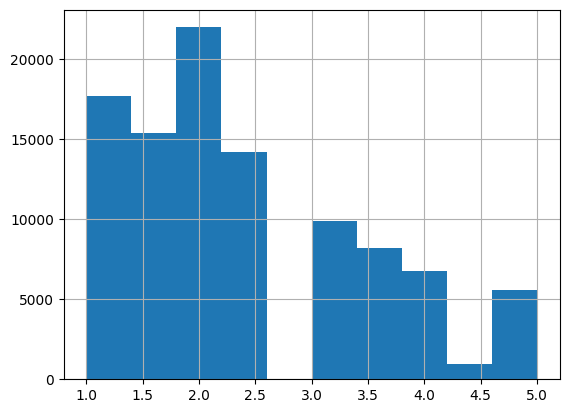

In [ ]:
train_df["rating"].hist()

<Axes: >

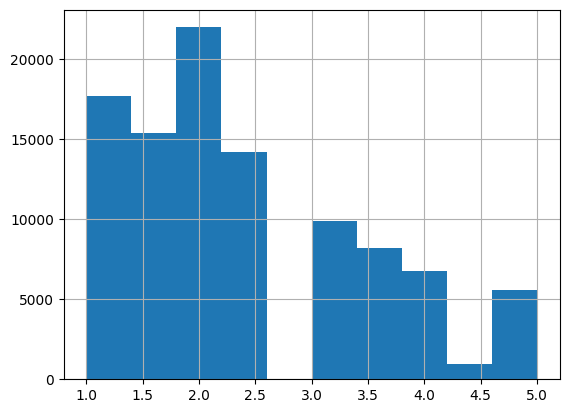

In [ ]:
# plot the rating hist in train_df for only the users with less than X (X will be adjustable) reviews
train_df[train_df["user_id"].isin(user_counts[user_counts < 55545].index)][
    "rating"
].hist()

In [ ]:
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean

user_id
1       3.910462
2       3.813296
3       2.748508
4       2.234422
5       2.169215
          ...   
239     2.054393
311     2.172026
315     1.450794
472     1.580508
1837    2.210942
Name: rating, Length: 123, dtype: float64

Number of missing books in test not in train: 0
Book counts:
book_id
408       257
748       213
522       149
356       142
26        142
         ... 
247693      1
248107      1
245643      1
246570      1
246356      1
Name: count, Length: 15712, dtype: int64


<Axes: >

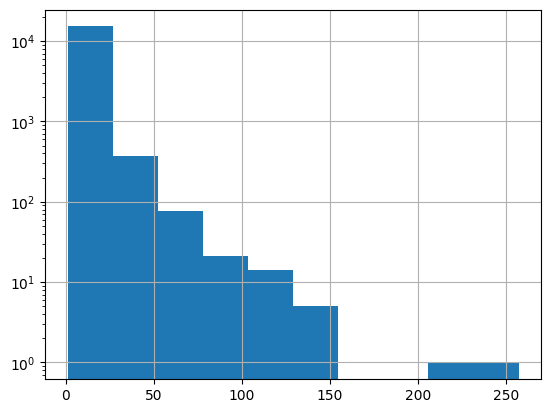

In [ ]:
import pandas as pd

test_df = pd.read_csv("../data/test.csv")
train_data = pd.read_csv("../data/train.csv")
test_books = set(test_df["book_id"].unique())
train_books = set(train_data["book_id"].unique())

missing_books = test_books - train_books
print(f"Number of missing books in test not in train: {len(missing_books)}")
if len(missing_books) > 0:
    print("Missing books:", missing_books)


# print number of occurrences of each book in the train data
book_counts = train_data["book_id"].value_counts()
print("Book counts:")
print(book_counts)

# show the occurences histogram in log scale
book_counts.hist(bins=10, log=True)

In [ ]:
# sort the rating of the books by the number of occurrences
book_counts_sorted = book_counts.sort_values(ascending=False)
print("Book counts sorted:")
print(book_counts_sorted)

# show the top 10 books with the most occurrences
top_books = book_counts_sorted.head(100)
print("Top books:")
print(top_books)

# get the each avg rating of the top books
top_books_ratings = (
    train_data[train_data["book_id"].isin(top_books.index)]
    .groupby("book_id")["rating"]
    .mean()
)
print("Top books ratings:")
print(top_books_ratings)

Book counts sorted:
book_id
408       257
748       213
522       149
356       142
26        142
         ... 
245793      1
249072      1
248519      1
66651       1
249242      1
Name: count, Length: 15712, dtype: int64
Top books:
book_id
408     257
748     213
522     149
356     142
26      142
       ... 
5873     58
2527     57
2488     57
516      56
1051     56
Name: count, Length: 100, dtype: int64
Top books ratings:
book_id
18        2.256944
26        3.915493
28        2.065789
37        1.453271
67        1.898810
            ...   
5873      1.974138
5887      1.768116
6330      1.427536
6933      1.406780
243217    4.206349
Name: rating, Length: 100, dtype: float64
